# Import

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2
from sklearn.metrics import accuracy_score as ACC
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from statsmodels.graphics.api import abline_plot
from skorch.callbacks import EpochScoring
from sklearn.model_selection import GridSearchCV,KFold,StratifiedKFold,cross_val_score
from skorch.callbacks import Checkpoint
from skorch.callbacks import EarlyStopping
import skorch
import statsmodels.api as sm
from skorch import NeuralNetRegressor
import os

from rdkit import Chem
from rdkit.Chem import AllChem

In [171]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Load data

In [15]:
train = pd.read_csv('../data/train_data.csv')
test = pd.read_csv('../data/test_data.csv')

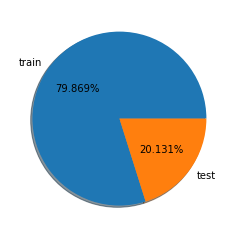

In [16]:
plt.pie([len(train), len(test)],
        labels = ['train','test'],
        autopct='%1.3f%%',shadow=True);

In [17]:
train.head()

,smiles_parents,LogKOH,Class
0,ClC(C(Cl)(Cl)Cl)Cl,7.000,halogeneted
1,N#CC#N,7.000,nitrile
2,C(Cl)(Br)C(F)(F)F,7.114,halogeneted
3,C(C)#N,7.342,nitrile
4,C(C)(=O)O,7.362,carboxyl


In [18]:
train.isnull().sum() # check missing value

smiles_parents    0
LogKOH            0
Class             0
dtype: int64

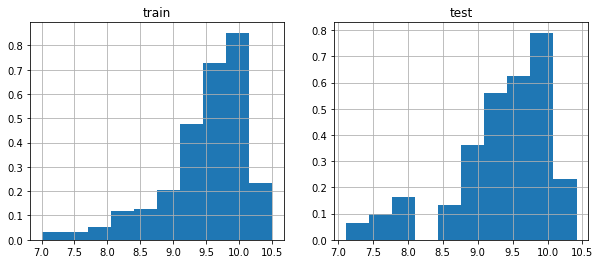

In [19]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
train['LogKOH'].hist(density=1)
plt.title('train')
plt.subplot(1, 2, 2)
test['LogKOH'].hist(density=1)
plt.title('test')
plt.show()

# Create fingerprint

In [18]:
def morgan_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024) # 32, 64......
    npfp = np.array(list(fp.ToBitString())).astype('int8')
    return npfp

In [19]:
train['fp'] = train["smiles_parents"].apply(morgan_fp)
test['fp'] = test["smiles_parents"].apply(morgan_fp)

In [20]:
train.head()

,smiles_parents,LogKOH,Unnamed: 2,fp
0,ClC(C(Cl)(Cl)Cl)Cl,7.000,halogeneted,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,N#CC#N,7.000,nitrile,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,C(Cl)(Br)C(F)(F)F,7.114,halogeneted,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,C(C)#N,7.342,nitrile,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,C(C)(=O)O,7.362,carboxyl,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [31]:
X_train = np.array(list(train.fp)).astype(np.float32)
X_test = np.array(list(test.fp)).astype(np.float32)
y_train = train['LogKOH'].values.reshape(-1,1).astype(np.float32)
y_test = test['LogKOH'].values.reshape(-1,1).astype(np.float32)

In [32]:
X_train.shape, y_train.shape

((365, 1024), (365, 1))

In [33]:
X_test.shape, y_test.shape

((92, 1024), (92, 1))

# Pytorch

In [62]:
class MLP_regressor(nn.Module):
    def __init__(self,input_size,n_hidden,layers_size,output_size,dropout):
        super(MLP_regressor, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.n_hidden = n_hidden
        self.input_linear = nn.Linear(input_size, layers_size)
        self.hidden_linear = nn.Linear(layers_size, layers_size)
        self.output_linear = nn.Linear(layers_size, output_size)
    def forward(self, X):
        h_relu = F.relu(self.input_linear(X))
        h_relu = self.dropout(h_relu)         
        for i in range(self.n_hidden-1):
            h_relu = F.relu(self.hidden_linear(h_relu))
            h_relu = self.dropout(h_relu)      
        y_pred = self.output_linear(h_relu)
        return y_pred

In [69]:
def build_NN(x,y,train_split):
    #auc = EpochScoring(scoring='roc_auc', lower_is_better=False)
    #f1 = EpochScoring(scoring='f1', lower_is_better=False) #for binary targets
    #r2 = EpochScoring(scoring='r2', lower_is_better=False)
    #mse = EpochScoring(scoring='neg_mean_squared_error', lower_is_better=False)   

    if train_split == True:
        cp = Checkpoint(f_params="params.pt",monitor='valid_loss_best')
        es = EarlyStopping(monitor='valid_loss', patience=200, threshold=0.0001)
        split = skorch.dataset.CVSplit(cv=5, stratified=False, random_state=3)
        callbacks = [cp,es]
    else:
        split = None
        callbacks = None
           
    net = NeuralNetRegressor(
        module=MLP_regressor,
        module__input_size=x.shape[1],
        module__n_hidden=2,
        module__layers_size=512,
        module__output_size=1,
        module__dropout=0.3,
        criterion=torch.nn.MSELoss,
        optimizer=torch.optim.Adam,#SGD,#Adam(Module.parameters()),
        optimizer__weight_decay=0.05,
        lr=1e-3,
        train_split=split,
        callbacks=callbacks,
        max_epochs=500,
        batch_size=64, # -1 means single batch
        device=('cuda' if torch.cuda.is_available() else 'cpu'), # cuda
        )
    return net

In [70]:
net = build_NN(X_train,y_train,train_split=True)
net.fit(X_train, y_train)

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1       91.1777       63.0760     +  0.0142
      2       69.1144       38.7101     +  0.0116
      3       27.6968        7.7844     +  0.0146
      4       20.2709        5.0366     +  0.0121
      5       10.0397        8.0051        0.0105
      6        7.3932        9.9061        0.0124
      7        6.2621        5.8977        0.0123
      8        3.3264        4.7223     +  0.0119
      9        3.3881        4.6189     +  0.0109
     10        2.4149        5.2518        0.0129
     11        2.0520        4.9592        0.0155
     12        1.5773        4.5261     +  0.0154
     13        1.5218        4.5246     +  0.0118
     14        1.2747        4.6637        0.0104
     15        1.1681        4.5694        0.0117
     16        0.9952        4.4516     +  0.0103
     17        0.8939        4.3919     +  0.0106
     18        0.8899        4.2944     +  0.0121


    144        0.3873        0.8111        0.0108
    145        0.3072        0.6682        0.0101
    146        0.3323        0.7646        0.0105
    147        0.3189        0.7614        0.0100
    148        0.3181        0.8224        0.0101
    149        0.3396        0.8936        0.0103
    150        0.2574        0.7171        0.0105
    151        0.3393        0.6734        0.0108
    152        0.3267        0.9797        0.0103
    153        0.3261        0.7061        0.0104
    154        0.3338        0.7393        0.0102
    155        0.3482        0.8993        0.0101
    156        0.4158        0.6552     +  0.0108
    157        0.3177        0.7272        0.0106
    158        0.3861        0.9434        0.0115
    159        0.3581        0.6758        0.0113
    160        0.3970        0.5867     +  0.0107
    161        0.4150        0.9424        0.0112
    162        0.4161        1.1355        0.0116
    163        0.5042        0.5495     +  0.0124


    306        0.3524        0.3843        0.0107
    307        0.3107        0.7329        0.0113
    308        0.3191        1.1639        0.0115
    309        0.3304        0.3874        0.0108
    310        0.3898        0.4875        0.0110
    311        0.4105        1.4939        0.0109
    312        0.3686        0.5286        0.0102
    313        0.3211        0.4340        0.0120
    314        0.2979        0.6173        0.0111
    315        0.2731        0.9045        0.0102
    316        0.3400        0.5338        0.0105
    317        0.3100        0.5899        0.0112
    318        0.2989        0.6405        0.0111
    319        0.2881        0.7943        0.0132
    320        0.3021        0.5195        0.0110
    321        0.2594        0.7542        0.0102
    322        0.2843        0.6144        0.0111
    323        0.2695        0.5113        0.0110
    324        0.3108        1.3271        0.0104
    325        0.4468        0.5242        0.0106


    470        0.4026        0.9226        0.0108
    471        0.3544        1.7544        0.0102
    472        0.5191        0.4087        0.0110
    473        0.4840        0.3124        0.0125
    474        0.6478        2.1198        0.0118
    475        0.6398        0.8363        0.0104
    476        0.4222        0.3444        0.0112
    477        0.4500        0.6572        0.0113
    478        0.5303        1.8966        0.0102
    479        0.6660        0.2989        0.0119
    480        0.5503        0.4509        0.0118
    481        0.4445        1.6050        0.0104
    482        0.3621        0.6203        0.0105
    483        0.2684        0.7264        0.0109
    484        0.3081        0.7147        0.0103
    485        0.2673        0.4528        0.0109
    486        0.2638        1.1316        0.0103
    487        0.3882        0.7903        0.0114
    488        0.3147        0.3477        0.0112
    489        0.3740        1.2242        0.0103


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MLP_regressor(
    (dropout): Dropout(p=0.3)
    (input_linear): Linear(in_features=1024, out_features=512, bias=True)
    (hidden_linear): Linear(in_features=512, out_features=512, bias=True)
    (output_linear): Linear(in_features=512, out_features=1, bias=True)
  ),
)

In [123]:
def params_Opt(x,y,net,params):
    n_trial = 1
    scores = []
    scoring = 'neg_mean_squared_error'  
    for i in range(n_trial):
         cv = KFold(n_splits=5, shuffle=True, random_state=i)
         gs = GridSearchCV(net, params, refit=True, cv=cv, scoring=scoring, verbose=2,n_jobs=5,return_train_score=True) 
         gs.fit(x, y)
         scores.append(gs.best_score_)
    print ("Average Score: {0} STD: {1}".format(np.mean(scores), np.std(scores)))
    print(gs.best_score_, gs.best_params_)
    return gs

In [129]:
params_grid = {
'module__n_hidden': [1,2,3],
'module__layers_size': [4,8,16,32,64,128,256],
'module__dropout': [0,0.3,0.5],
'optimizer__weight_decay': [0,1e-3,1e-2,1e-1]
}

params = {
'module__n_hidden': [2],
'module__layers_size': [1024],
'module__dropout': [0.5],
'optimizer__weight_decay': [0.01]
}

In [130]:
net_grid = build_NN(X_train,y_train,train_split=False)
model = params_Opt(X_train,y_train,net_grid,params)   

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.6min


  epoch    train_loss     dur
-------  ------------  ------
      1       58.1399  0.0167
      2       19.3460  0.0176
      3        8.9963  0.0190
      4        5.9297  0.0184
      5        4.0398  0.0165
      6        2.9693  0.0177
      7        2.2525  0.0183
      8        1.9947  0.0175
      9        1.6051  0.0182


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.7min finished


     10        1.4411  0.0182
     11        1.3424  0.0177
     12        1.2640  0.0178
     13        1.2429  0.0186
     14        0.9639  0.0170
     15        1.0141  0.0175
     16        1.4762  0.0171
     17        1.8799  0.0167
     18        1.8590  0.0166
     19        2.8695  0.0161
     20        1.9701  0.0163
     21        1.1174  0.0163
     22        1.2698  0.0170
     23        1.0336  0.0168
     24        1.1696  0.0170
     25        1.5877  0.0173
     26        1.6062  0.0163
     27        1.2577  0.0162
     28        1.7753  0.0167
     29        1.3977  0.0164
     30        1.2469  0.0166
     31        1.0188  0.0169
     32        1.2498  0.0160
     33        2.1031  0.0180
     34        1.7666  0.0161
     35        2.9989  0.0160
     36        2.0970  0.0163
     37        1.3387  0.0162
     38        1.2788  0.0165
     39        1.2354  0.0163
     40        1.0673  0.0165
     41        1.1474  0.0165
     42        1.2476  0.0167
     43   

    280        1.1205  0.0172
    281        0.7684  0.0170
    282        1.1873  0.0166
    283        0.4316  0.0167
    284        0.6774  0.0168
    285        0.6185  0.0162
    286        0.6294  0.0177
    287        0.6075  0.0168
    288        0.5985  0.0176
    289        1.0401  0.0184
    290        0.4500  0.0161
    291        0.7250  0.0166
    292        0.5868  0.0166
    293        1.1122  0.0174
    294        1.0594  0.0166
    295        0.4376  0.0169
    296        0.6568  0.0166
    297        0.6561  0.0174
    298        0.6533  0.0176
    299        0.8443  0.0161
    300        0.7231  0.0162
    301        0.5633  0.0165
    302        0.4281  0.0173
    303        0.4571  0.0170
    304        0.3782  0.0170
    305        0.5504  0.0164
    306        0.6849  0.0168
    307        0.7923  0.0165
    308        0.8365  0.0169
    309        0.6876  0.0169
    310        0.9920  0.0170
    311        0.3455  0.0169
    312        0.6001  0.0164
    313   

    549        0.2337  0.0170
    550        0.2959  0.0166
    551        0.2438  0.0170
    552        0.2659  0.0168
    553        0.3233  0.0170
    554        0.2604  0.0163
    555        0.2147  0.0164
    556        0.2485  0.0167
    557        0.2634  0.0166
    558        0.2501  0.0165
    559        0.2355  0.0172
    560        0.2289  0.0166
    561        0.2963  0.0169
    562        0.2411  0.0169
    563        0.2684  0.0169
    564        0.3213  0.0170
    565        0.2196  0.0172
    566        0.2342  0.0170
    567        0.2623  0.0165
    568        0.2593  0.0166
    569        0.2586  0.0169
    570        0.2565  0.0169
    571        0.2262  0.0168
    572        0.2489  0.0166
    573        0.2765  0.0166
    574        0.2149  0.0166
    575        0.2172  0.0163
    576        0.2528  0.0166
    577        0.2263  0.0176
    578        0.2448  0.0164
    579        0.2872  0.0169
    580        0.2810  0.0166
    581        0.2093  0.0165
    582   

    821        0.2542  0.0176
    822        0.2088  0.0172
    823        0.2611  0.0176
    824        0.2252  0.0173
    825        0.1874  0.0174
    826        0.2671  0.0167
    827        0.2630  0.0169
    828        0.2292  0.0166
    829        0.2512  0.0168
    830        0.2423  0.0169
    831        0.2330  0.0170
    832        0.2493  0.0178
    833        0.2403  0.0168
    834        0.2442  0.0175
    835        0.2220  0.0173
    836        0.2079  0.0167
    837        0.2393  0.0172
    838        0.2129  0.0172
    839        0.2639  0.0171
    840        0.2168  0.0170
    841        0.2154  0.0175
    842        0.2402  0.0166
    843        0.2981  0.0171
    844        0.2522  0.0174
    845        0.2334  0.0170
    846        0.2259  0.0172
    847        0.2717  0.0170
    848        0.2854  0.0175
    849        0.2709  0.0175
    850        0.2454  0.0167
    851        0.2196  0.0171
    852        0.2140  0.0170
    853        0.2670  0.0169
    854   

   1094        0.2322  0.0173
   1095        0.3132  0.0173
   1096        0.2658  0.0170
   1097        0.2169  0.0175
   1098        0.2142  0.0174
   1099        0.2758  0.0173
   1100        0.1919  0.0179
   1101        0.2018  0.0169
   1102        0.2385  0.0176
   1103        0.2216  0.0179
   1104        0.1997  0.0169
   1105        0.1920  0.0172
   1106        0.2172  0.0176
   1107        0.2025  0.0166
   1108        0.2386  0.0174
   1109        0.2646  0.0173
   1110        0.2709  0.0168
   1111        0.1989  0.0175
   1112        0.2133  0.0173
   1113        0.2006  0.0170
   1114        0.1882  0.0170
   1115        0.2123  0.0174
   1116        0.1930  0.0173
   1117        0.2145  0.0170
   1118        0.2331  0.0169
   1119        0.2201  0.0178
   1120        0.1971  0.0168
   1121        0.1917  0.0172
   1122        0.1925  0.0175
   1123        0.1707  0.0169
   1124        0.2112  0.0173
   1125        0.3105  0.0173
   1126        0.2369  0.0170
   1127   

   1366        0.2065  0.0170
   1367        0.1836  0.0174
   1368        0.2145  0.0170
   1369        0.2318  0.0171
   1370        0.1859  0.0174
   1371        0.1850  0.0173
   1372        0.1859  0.0173
   1373        0.2113  0.0172
   1374        0.1781  0.0175
   1375        0.2955  0.0173
   1376        0.1863  0.0174
   1377        0.2061  0.0174
   1378        0.2525  0.0183
   1379        0.1989  0.0179
   1380        0.1927  0.0171
   1381        0.2640  0.0173
   1382        0.1905  0.0174
   1383        0.1966  0.0174
   1384        0.1986  0.0171
   1385        0.1949  0.0168
   1386        0.3481  0.0167
   1387        0.2419  0.0167
   1388        0.2270  0.0166
   1389        0.1944  0.0167
   1390        0.2130  0.0178
   1391        0.2258  0.0167
   1392        0.1893  0.0192
   1393        0.1847  0.0190
   1394        0.2495  0.0176
   1395        0.2726  0.0183
   1396        0.2349  0.0180
   1397        0.2194  0.0173
   1398        0.1712  0.0170
   1399   

   1639        0.2138  0.0171
   1640        0.2042  0.0176
   1641        0.2416  0.0176
   1642        0.1939  0.0175
   1643        0.2578  0.0193
   1644        0.2720  0.0178
   1645        0.1950  0.0182
   1646        0.1837  0.0177
   1647        0.1738  0.0177
   1648        0.2190  0.0178
   1649        0.2390  0.0177
   1650        0.2465  0.0176
   1651        0.1618  0.0176
   1652        0.1910  0.0182
   1653        0.2295  0.0179
   1654        0.1901  0.0185
   1655        0.2240  0.0178
   1656        0.1492  0.0178
   1657        0.2332  0.0177
   1658        0.2040  0.0184
   1659        0.1891  0.0171
   1660        0.1803  0.0176
   1661        0.2166  0.0174
   1662        0.2225  0.0176
   1663        0.1772  0.0183
   1664        0.1613  0.0171
   1665        0.1964  0.0175
   1666        0.1450  0.0187
   1667        0.2074  0.0179
   1668        0.2717  0.0176
   1669        0.2149  0.0173
   1670        0.1973  0.0180
   1671        0.2206  0.0174
   1672   

   1912        0.1926  0.0171
   1913        0.2151  0.0178
   1914        0.1689  0.0181
   1915        0.1970  0.0172
   1916        0.1759  0.0175
   1917        0.2033  0.0182
   1918        0.1580  0.0179
   1919        0.1879  0.0183
   1920        0.1609  0.0177
   1921        0.1882  0.0178
   1922        0.1519  0.0184
   1923        0.2212  0.0177
   1924        0.1799  0.0176
   1925        0.2789  0.0179
   1926        0.1982  0.0177
   1927        0.1952  0.0176
   1928        0.1455  0.0179
   1929        0.1515  0.0180
   1930        0.2458  0.0172
   1931        0.2772  0.0174
   1932        0.1748  0.0178
   1933        0.1792  0.0179
   1934        0.1791  0.0174
   1935        0.1520  0.0176
   1936        0.1547  0.0173
   1937        0.1461  0.0172
   1938        0.2220  0.0180
   1939        0.2001  0.0179
   1940        0.1833  0.0174
   1941        0.2508  0.0174
   1942        0.2670  0.0171
   1943        0.2153  0.0176
   1944        0.1899  0.0175
   1945   

In [118]:
cv_results = model.cv_results_
cv_results = pd.DataFrame.from_dict(cv_results)

In [119]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_module__dropout,param_module__layers_size,param_module__n_hidden,param_optimizer__weight_decay,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,97.367141,2.193577,0.003506,0.00335,0.3,1024,2,0.01,"{'module__dropout': 0.3, 'module__layers_size'...",-0.151675,-0.190134,-0.208266,-0.232229,-0.279876,-0.21227,0.042829,1,-0.028443,-0.048931,-0.031468,-0.020755,-0.038619,-0.033643,0.009554


In [131]:
y_pred = model.predict(X_test)    
MSE(y_pred,y_test)

0.25262493

(7, 11)

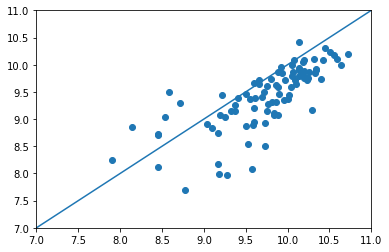

In [121]:
plt.scatter(y_pred, y_test)
xx = np.arange(7,12)
yy = xx
plt.plot(xx,yy)
plt.xlim([7,11])
plt.ylim([7,11])

# Fast ai

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.utils.data as utils
from torch.optim.lr_scheduler import CosineAnnealingLR

from fastai.basics import *
from fastai.callbacks import *

In [44]:
class create_dataset(Dataset):

    def __init__(self, train_x, train_y):
        self.X = train_x
        self.y = train_y

    def __getitem__(self, item):
        x_t = self.X[item]
        y_t = self.y[item]
        return x_t, y_t

    def __len__(self):

        return len(self.X)

In [45]:
trn_ds = create_dataset(X_train, y_train)
val_ds = create_dataset(X_test, y_test)


# needed until fastai gets updated
#val_ds.loss_func = nn.MSELoss()
#trn_ds.loss_func = nn.MSELoss()

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

databunch = DataBunch.create(trn_ds,val_ds, device=device, bs=50)

In [55]:
net = torch.nn.Sequential(
    torch.nn.Linear(1024, 1024),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(1024, 1024),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(1024, 1024),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(1024, 1,))

In [60]:
# fit model
input_size = X_train.shape[1]
hidden_size = 1024
num_layers = 3
output_size = 1
dropout = 0.2

net = MLP_regressor(input_size, num_layers, hidden_size, output_size, dropout)
criterion =  nn.MSELoss() 
learn = Learner(databunch,net,callback_fns=[ShowGraph,partial(EarlyStoppingCallback, monitor='val_loss', 
        min_delta=0.0001, patience=50), SaveModelCallback], loss_func = criterion, metrics = 
                [mean_absolute_error, root_mean_squared_error])

In [57]:
print(net)

Sequential(
  (0): Linear(in_features=1024, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2)
  (3): Linear(in_features=1024, out_features=1024, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5)
  (6): Linear(in_features=1024, out_features=1024, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5)
  (9): Linear(in_features=1024, out_features=1, bias=True)
)


epoch,train_loss,valid_loss,mean_absolute_error,root_mean_squared_error,time
0,84.008514,66.867012,8.152931,8.172379,00:00
1,61.325871,7.570885,2.233721,2.750365,00:00
2,46.434669,14.399164,2.991658,3.781236,00:00
3,35.082310,11.856139,3.190578,3.437712,00:00
4,29.634111,12.497168,3.333010,3.527467,00:00
5,24.407291,3.668038,1.432705,1.913824,00:00
6,20.433968,8.080561,2.167270,2.842368,00:00
7,17.249647,3.281232,1.405028,1.808512,00:00
8,14.722009,5.084699,1.995530,2.252182,00:00
9,12.614374,2.735288,1.236648,1.653403,00:00


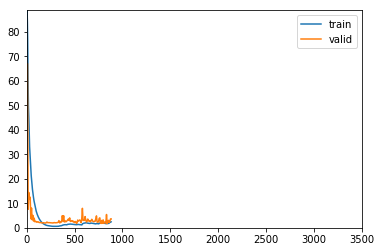

Traceback (most recent call last):
  File "/home/jiajie/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/jiajie/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/jiajie/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/jiajie/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/jiajie/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/jiajie/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/jiajie/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._

KeyboardInterrupt: 

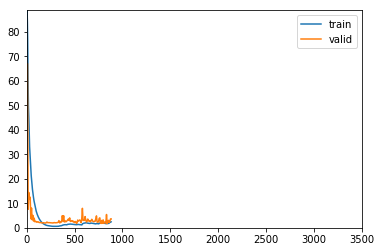

In [61]:
lr=0.01
learn.fit_one_cycle(500, lr)